# Speech Processing - Instituto Superior Técnico
### Laboratory Assignment 2 - Spoken Language Indentification challenge

The second laboratory assignment of the course is designed to simulate a **spoken language identification** challenge. In this challenge, partipants (a.k.a students enrolled in the course) receive a train, development and evaluation (blind) data set, and a simple (and weak) baseline system for the task at hand: closed-set identification of the spoken language in a given audio file out of a set of six target langauges: Basque,  Catalan,  English,  Galician,  Portuguese and  Spanish.

The **goal** for each participant is to develop/build the best spoken language identification system. To this end, participants are encouraged to modify this baseline, incorporate any other techniques and in general explore any approach that permit  improving their results.

During the first week (Part 1), students are expected to:
- Run and understand the main components of the baseline.
- Propose and develop simple modifications to the baseline feature extraction process.
- Propose and develop simple modifications to the baseline GMM language models.
- Evaluate the models on the development partition.

During the second week (Part 2), students are expected to:
- Propose and develop other *classical* modifications to any component of the processing pipeline (openSMILE features, segment-based features, SVM classifiers, MLP/CNN classifiers, etc.)
- Run and understand the second part of Notebook that explores a pre-trained model.
- Propose and develop more recent advanced approaches, including x-vectors.
- Evaluate the models on the development partition.
- Obtain predictions for the blind test partition and prepare the submission.

The challenge distinguishes two different tracks or evaluation conditions:
- Track 1 - Participants are not allowed to use any kind of pre-trained model (such as x-vectors).
- Track 2 - Participants are allowed to use anything.


## About the data

The data consists of mono audio files sampled at 16 kHz all of them containing speech of only one of the following target languages:
```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

The dataset is organized in 4 partitions:
- `'train'`: This is the full training set, consisting of 3060 clean audio samples correponding to speech segments of TV broadcast shows. (**ATENTION**: Do not use this dataset for training your models, unless your system is very fast or if you want to build your final model. It can be slow)
- `'train100'`: This is a subset of the full training set that consists of 100 audio files per target language (**RECOMMENDATION**: Use this partition in your quick experiments, to more rapidly validate alternatives)
- `'dev'`: This is the development set. It contains audio extracted from YouTube. You will typically use this to validate the quality of your model.
- `'evl'`: This is the evaluation set. It contains audio extracted from YouTube. You don't have the groud-truth for this set. You are expected to produce it and submit it.

The data used in this challenge is a subset of the KALAKA-3 database: https://aclanthology.org/L14-1576/

The  difference is that only the clean train audio segments and the Plenty Closed evaluation condition have been considered. 

## Before starting
The following conditions are neecessary to run correctly this notebook:

*   All modules included in the requirements file need to be 
installed in the Python environment.
*   The module `pf_tools` needs to be accessible (if you are using Google Colab, you will need to copy the `pf_tools.py` every time you start a new session).

In [1]:
from pf_tools import CheckThisCell

## How can you download (and process) the data

The first thing we have to do is to set our working directory. If you are using Google Colab, you  probably want to mount Google Drive to keep persistent information, such as data, features and models:

In [2]:
import os 
CWD = os.getcwd() # Change this variable to your working directory to store data, features and models
CWD

'/Users/duartealmeida/PF/Spoken-Language-Processing/lab02'

The class `Kalaka` permits downloading, transforming and storing the different data partitions. Each `Kalaka` instance can be used to iterate over all the samples of the partition. It can also be used in combination with pytorch dataloader to read batches of data to train neural networks with pytorch. For instance, consider the following piece of code:


In [3]:
import numpy as np
from pf_tools import Kalaka
import librosa 

def audio_transform(filename):
    y, _ = librosa.load(filename, sr=16000, mono=True)
    return y.reshape(-1,1)
    
trainkalaka = Kalaka(CWD, 'train100', transform_id='raw', audio_transform=audio_transform)

/Users/duartealmeida/PF/Spoken-Language-Processing/lab02/pf_tools.py:91: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")



This will first download and uncompress the .tar.gz file containing all the necessary data of the `'train100'` partition, that is, the audio files that are stored to disk (in CWD/train100/audio/) and key file (CWD/train100/key.lst). Then, the audio transformation `'transform'` will be applied to each file and the result stored to disk CWD/train100/raw/. 

**Audio transformations** receive a filename of an audio file and returns an array of dimensions (NxD), in which N is the time dimension and D the dimension of the feature vector. In this simple case D is 1 because the transform is just returning the raw audio signal.

The `Kalaka` class permits chunking the output of the audio transformation (of size NxD) in chunks of CxD size. The chunking operation divides the orignal sample, in multiple smaller samples with a configurable chunk size and hop length. These chunks can be further transformed and stored as individual feature files. For instance:

In [4]:
trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000)

This will download and uncompress the partition data, only if was not already done before. Then, as previously, the simple tranform that returns the waveform is applied to each audio file. After this, the resulting array of dimension Nx1, in which N=16000xduration_in_seconds, is split in continuous chunks of length 64000 (that is, 4 seconds) with chunk hop of 2 seconds. Each one of these chunks of 4 seconds is stored and will be accessed whenever we iterate the dataset. 

Adittionally, the optional argument `chunk_transform` pertmits defining a transformation to be applied to each chunk before storing to disk. It can be any function that receives an array of size CxD and returns an array HxW, in which H is the *new time dimension*. For instance, the following example takes the audio segments of 64000x1, computes the mean and variance every 0.1 sec (1600 samples) and returns a feature vector of size 40x2.

In [5]:
def chunk_transform(x):
    x = x.reshape(-1,1600)
    return np.concatenate((x.mean(axis=1, keepdims=True), x.std(axis=1, keepdims=True)),axis=1)

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)



Notice that, while the above example is probably useless as an effective feature extraction method, the proper combination of audio and chunk transformations is expected to permit quite flexible feature extraction that (hopefully) can match the needs of almost any training setting. 

Once we have instanciated a Kalaka dataset, it can be iterated to have access to each processed sample, for instance: 

In [6]:
import time
start = time.time()
for i, sample in enumerate(trainkalaka):
    data, label, basename = sample # array, int, str
    if i % 1000 == 0:
        print(i, data.shape, label, basename)

print(f'Finished reading all data in {time.time() - start}')

0 (40, 2) 6 0006ebda
1000 (40, 2) 1 11a3790f
2000 (40, 2) 4 271621da
3000 (40, 2) 5 3b9d2c2f
4000 (40, 2) 1 4d10f8f2
5000 (40, 2) 6 5fb949a1
6000 (40, 2) 6 70d28e30
7000 (40, 2) 6 7d5515f0
8000 (40, 2) 3 937623c2
9000 (40, 2) 5 a4a7491b
10000 (40, 2) 5 bc3f6e51
11000 (40, 2) 3 cd82bcca
12000 (40, 2) 1 df0b27f2
13000 (40, 2) 3 f3ba1f4d
Finished reading all data in 3.683227300643921


Now you can use the `Kalaka` class to check the  number of files and size (in minutes) of the training set for each target language. You cankKeep these numbers to include in your system description paper:

In [7]:
# Inspect the training data to find the size of each training language
num_files, minutes = trainkalaka.get_metrics_per_language()

print("Number of files per language:\n\tBasque: {}\n\tCatalan: {}\n\tEnglish: {}\n\tGalician: {}\n\tPortuguese: {}\n\tSpanish: {}\n"\
    .format(num_files['Basque'], num_files['Catalan'], num_files['English'], num_files['Galician'], num_files['Portuguese'], num_files['Spanish']))
print("Minutes per language:\n\tBasque: {}\n\tCatalan: {}\n\tEnglish: {}\n\tGalician: {}\n\tPortuguese: {}\n\tSpanish: {}\n"\
    .format(minutes['Basque'], minutes['Catalan'], minutes['English'], minutes['Galician'], minutes['Portuguese'], minutes['Spanish']))

#raise CheckThisCell ## <---- Remove this after completeing/checking this cell

  0%|                                                                                                     | 0/600 [00:00<?, ?it/s]/Users/duartealmeida/PF/Spoken-Language-Processing/lab02/pf_tools.py:145: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  minutes[language] += librosa.get_duration(filename=audioin)
100%|███████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:18<00:00, 32.43it/s]

Number of files per language:
	Basque: 100
	Catalan: 100
	English: 100
	Galician: 100
	Portuguese: 100
	Spanish: 100

Minutes per language:
	Basque: 4743.38
	Catalan: 5111.188999999999
	English: 5254.2998125
	Galician: 4833.832437500003
	Portuguese: 4569.997062499999
	Spanish: 4745.947999999998



Notice that the `Kalaka` class extends the `torch.utils.data.Dataset` and it can be used in combination with a Pytorch DataLoader to read data in batches:

In [8]:
import torch 

trainkalaka = Kalaka(CWD, 'train100', 
                     transform_id='chunks_mv', 
                     audio_transform=audio_transform, 
                     chunk_size=4*16000, 
                     chunk_hop=2*16000, 
                     chunk_transform=chunk_transform)

dataloader = torch.utils.data.DataLoader(
        dataset=trainkalaka,
        batch_size=10,
        shuffle=True
)

start = time.time()
for i, batch in enumerate(dataloader):
    data, label, basename = batch
    if i % 100 == 0:
        print(data.shape, label.shape, len(basename))

print(f'Finished reading all data in {time.time() - start}')


/Users/duartealmeida/PF/Spoken-Language-Processing/lab02/pf_tools.py:91: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
torch.Size([10, 40, 2]) torch.Size([10]) 10
Finished reading all data in 1.649137020111084


Finally, remind that you can change anything you want. This includes the Kalaka class. Eventually, you can decide not using it at all and loading the data in some alternative way.  You can inspect the class to find the URLs for downloading the datasets. It is up to you! 

Before moving to the next stage, you probably want to delete the folders containing the dummy features that you just generated.

# PART 1 - The baseline (Track 1)
The baseline consists of MFCC feature extraction  (based on the `librosa` module) with SDC computation and VAD removal, followed by GMMs of 64 dimensions for each language (using the `sklearn` module). The rest of this notebook contains the guide and code cells (some of them partially incomplete) that permit implementing this baseline and score it on the development set. Read carefully the Markdown information, but also the comments inside the code cells (they provide useful information and hints), and also the code itself. The better you understand it, the easier will be modyfing it.

## Initialization and importing modules

In [9]:
import os
from pf_tools import Kalaka
import librosa
import numpy as np
import torch
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import time
import random
import datetime
from pathlib import Path
import pickle
import csv 
from tqdm import tqdm

from nn import FeedforwardNetwork, ClassificationDataset
import torch.optim as optim
import torch.nn as nn

from parselmouth import praat

GLOBAL_SEED = 35731

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)


LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
LANG2ID = {'Basque':1, 'Catalan':2, 'English':3, 'Galician':4, 'Portuguese':5, 'Spanish':6}
ID2LANG = dict((LANG2ID[k],k)for k in LANG2ID)

## The baseline feature extraction module
The next function extracts MFCCs, but there are plenty of things that can be improved. You are free to change anything you want, including the number of formal parameters, the number of returned expressions, etc. 

In [10]:
import math
# Read carefully this function and understand it
def feat_extract(filename, orig_sr=16000, mono=True, n_mfcc = 13, remove_c0=False, delta_order=0, apply_sdc=False, apply_vad=False, apply_cmvn=False,
                 num_formants = 0, cluster_order = 0):
    
    sr=16000
    n_mels = 40
    n_fft = 512 
    hop_length = 160
    fmin = 50
    fmax = 7800
    
    if apply_sdc and (delta_order > 0):
        raise ValueError("Applying SDC and delta > 0 is not compatible")

    # Load audio wav into numpy array
    y, _ = librosa.load(filename, sr=orig_sr, mono=mono)
    
    # Resample in case it's needed
    if orig_sr != sr:
        y = librosa.resample(y, orig_sr=orig_sr,target_sr=sr)

    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK
    # 1 - PREPROCESSING - Typical preprocessing may include normalization of audio (mean removal), 
    #                       but also speech enhancement and others more complex

    # Extract MFFCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, 
                                n_mfcc=n_mfcc, n_mels=n_mels, 
                                hop_length=hop_length, 
                                fmin=fmin, fmax=fmax, htk=False).T
    
    ## OPTIONAL ADDIDITIONAL STAGES - LAB WORK

    # 2 Compute deltas --> Hint you can use librosa (order size may be a parameter?)
    if delta_order > 0:
        mfcc = compute_delta(mfcc)
    
    # 3 SDC --> Hint: You can build this using deltas (of extented context)  
    if apply_sdc:
        mfcc = compute_sdc(mfcc)
    
    # Compute formants
    if num_formants > 0:
        sound = parselmouth.Sound(filename)
        formants = praat.call(sound, "To Formant (burg)", (hop_length / sr), num_formants, 5500, (n_fft / sr), 50)
        all_formants = np.zeros((len(mfcc), num_formants))
        for i in range(len(mfcc)):
            t = i * (hop_length / sr)
            for j in range(num_formants):
                all_formants[i, j] = praat.call(formants, "Get value at time", j + 1, t, "Hertz", "Linear")
        mfcc = np.concatenate((mfcc, all_formants), axis = 1)
        mfcc = np.nan_to_num(mfcc)
        
    
    # 4 COMPUTE VAD --> Hint: You can use any vad (theshold energy, something avaialble in the net, a biGaussian model...).
    #                         Coeff0 is highly related with Energy and sometimes it is removed
    #                   ATTENTION: Using a VAD may have a significant impact  
    if apply_vad:
        energy = librosa.feature.rms(y = y, hop_length = hop_length)
        mfcc, vad = compute_vad(mfcc, energy = librosa.feature.rms(y = y, hop_length = hop_length).reshape(-1, 1))
        mfcc = mfcc[:, 1:]
             
    # 5 APPLY CMVN --> ATTENTION: Using normalization may have a significant impact
    if apply_cmvn:
        mfcc = compute_cmvn(mfcc)
        
    if cluster_order > 0:
        mfcc = KMeans(cluster_order).fit(mfcc).cluster_centers_
    #print(mfcc)
        
    
    return mfcc, y


Try to define some or all of the following steps to improve your feature extraction pipeline 

In [11]:
# Numpy arrays have methods to compute mean and variance, so this one should be really easy
def compute_cmvn(features):
    # subtract the mean and divide by the variance along each column
    if (features.shape[0] == 0):
        return features
    else:
        stddev = np.std(features, axis = 0)
        stddev[stddev == 0] = 1
        return (features - np.mean(features, axis = 0)) / stddev


In [12]:
# librosa contains functions to compute deltas
def compute_delta(features, win=3, delta_order=2, keep_static=True):
    deltas = librosa.feature.delta(features, width = win, order = 1)
    for i in range(1, delta_order):
        new_delta = librosa.feature.delta(features, width = win, order = i + 1)
        deltas = np.concatenate((deltas, new_delta), axis = 1)
    if keep_static:
        return np.concatenate((features, deltas), axis = 1)
    else:
        return deltas

In [13]:
# Compute deltas and then select previous and next deltas with fixed intervals to cocatentate. 
# You may need to code a bit here or dinf some function that helps with this
def compute_sdc(features, P=3, D=1, K=7, keep_static=True):
    N = len(features)
    
    # need to pad with D zeros before and after (to allow order-1 delta at all vectors)
    # need to pad with (K - 1) * P zeros at the end so that the last vector can have the other K - 1 deltas
    features_pad = np.pad(features, ((D, D + ((K - 1) * P)), (0, 0)), mode = "edge")
    
    # NOTE: librosa does not allow deltas at a window smaller than 3
    deltas = features_pad[2 * D:] - features_pad[0 : -2 * D]
    sdc = deltas[:N]
    # append the delta vector at distace k * P (k = 1, ..., K - 1)
    for k in range(1, K):
        sdc = np.concatenate((sdc, deltas[k * P: k * P + N]), axis = 1)
        
    if keep_static:
        return np.concatenate((features, sdc), axis = 1)
    else:
        return sdc


In [14]:
# You can think of several strattegies to compute VAD, simple ones based on energy and a threshold, or maybe some more 
# ellaborated ones, like training a GMM with 2 mixtures with the Energy. 
# In addition to the features without some frames, this function may return a sequence of 0s and 1s that helps you to validate the method.
def compute_vad(features, energy, y=None):
    gm = GaussianMixture(n_components = 2, random_state = GLOBAL_SEED).fit(energy)
    voiced = np.argmax(gm.means_)
    vad = gm.fit_predict(energy)
    voiced_features = features[vad == voiced]
    return voiced_features, vad

You can test in an isolated audio file and inspect the dimensions, verify that your code is doing what is expected, inspect and visualize the data using some of the lessons learnt in LAB1. Also, don't forget to listen some of the examples!!

In [15]:
#mfcc_sdc, _ = feat_extract('sample.wav', apply_cmvn=False, apply_sdc=True)
#mfcc_dd, _ = feat_extract('sample.wav', apply_cmvn=False, delta_order=2)
#mfcc_d, _ = feat_extract('sample.wav', apply_cmvn=False, delta_order=1)
#mfcc, y = feat_extract('sample.wav', apply_vad=True, num_formants = 5, cluster_order = 5)


To run the data processing stage for the train100 partition we will simply instanciate the Kalaka class as mentioned previosly. Take a sit because it can take a bit:

In [16]:
sr = 16000
sec = 8
hop_length = 160
vectors_4_sec = int((sr * sec) // hop_length)

transform = { 'mfcc_sdc_vad_chunk_300_300' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc=True, apply_vad=True, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
                 'mfcc13' : 
                 { 
                     'audio_transform': lambda x : feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 13, apply_sdc=False, apply_vad=False, apply_cmvn=True)[0],
                     'chunk_transform': None,
                     'chunk_size': 300,
                     'chunk_hop':300
                 },
                 'mfcc7' : 
                 { 
                     'audio_transform': lambda x: feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc = False, apply_vad = True, apply_cmvn = True)[0],
                     'chunk_transform': None,
                     'chunk_size': vectors_4_sec,
                     'chunk_hop': vectors_4_sec
                 },
                 'mfcc7_delta_deltadelta' : 
                 { 
                     'audio_transform': lambda x: feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 7, apply_sdc = False, delta_order = 2, apply_vad = True, apply_cmvn = True)[0],
                     'chunk_transform': None,
                     'chunk_size': vectors_4_sec,
                     'chunk_hop': vectors_4_sec
                 },
                 'mfcc4_formants5_cluster' : 
                 { 
                     'audio_transform': lambda x: feat_extract(x, orig_sr=16000, mono=True, n_mfcc = 4, apply_sdc = False, apply_vad = True, apply_cmvn = True, num_formants = 5)[0],
                     'chunk_transform': None,
                     'chunk_size': 300, 
                     'chunk_hop': 300, 
                 },
            }


trainset = 'train100'
transform_id = 'mfcc_sdc_vad_chunk_300_300'

trainkalaka = Kalaka(CWD, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


/Users/duartealmeida/PF/Spoken-Language-Processing/lab02/pf_tools.py:91: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


## The baseline spoken language models
The baseline model is extremely simple: we'll train an individual GMM model for each language on top of the features that we just extracted. Later, in prediction time, given a test audio sample, we'll compute the loglikelihood obtained with each GMM model and select as the identified language the one whose model gives the highest likelihood. Let's go for it!!


In [17]:
# IN GMM training each training sample contains more than one frame;
# so we cocatenate all data to have all training datain one array 
# and the corresponding label with same time duration
# actually, here the chunking process is useless, 
#I could have obtained the same without chunking (with slight differences due to trunkation)

start = time.time()
train_data = []
train_labels = []
dict_languages = {}
for data, label, basename in trainkalaka:
    train_data.append(data)
    train_labels.append(np.full(data.shape[0], label)) 
    
#train_data = np.concatenate(train_data)
#train_labels = np.concatenate(train_labels)
#train_basenames = np.concatenate(train_basenames)

#new_train_data = []
#new_train_labels = []
#for basename in basenames:
#    vectors = train_data[train_basenames == basename]
#    label = train_labels[train_basenames == basename][0]
#    vectors_tr = vectors[:len(vectors) - (len(vectors) % 1000)]
#    new_vectors = vectors_tr.reshape((-1, 1000, vectors_tr.shape[1]))
#    new_train_data.append(new_vectors)
#    new_train_labels.append(np.full(new_vectors.shape[0], label - 1))

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print(train_data.shape)
print(train_labels.shape)

print(f'Finished reading all data in {time.time() - start}')

(1667100, 55)
(1667100,)
Finished reading all data in 5.030212879180908


Now we have two arrays containing the complete training dataset and the corresponging reference labels. Check the sizes, may be have a look to the content of one time instant. Do some checks on the data to be sure that everything is as expected:

In [18]:
# Check the traininig data. Notice that if you apply VAD, the size of the training data must be smaller than the complete data set. 
# Register the size in frames and in time of training data for each language
#raise CheckThisCell ## <---- Remove this after completeing/checking this cell

Let's go training. Again, depending of the amount of data used, the model complexity and computational resources of the machine that you're using, this can take a while. So, relax while the computer works for you!

In [19]:
# TRAIN GMM models (ML) 

print(train_data.shape)
models = {}
n_gauss = 256
for lang in LANGUAGES:
    models[lang] = GaussianMixture(
                        n_components=n_gauss, 
                        covariance_type='diag', 
                        max_iter=20, n_init=1, 
                        init_params='kmeans', 
                        verbose=2, 
                        verbose_interval=1)
    #models["not_" + lang] = GaussianMixture(
    #                    n_components=n_gauss, 
    #                    covariance_type='diag', 
    #                    max_iter=20, n_init=1, 
    #                    init_params='kmeans', 
    #                    verbose=2, 
    #                    verbose_interval=1)
    
for lang in LANGUAGES:
    print(f'Training model for {lang}')
    models[lang].fit(train_data[train_labels==LANG2ID[lang]])
    
    #print(f'Training model for not {lang}')
    #models["not_" + lang].fit(train_data[train_labels!=LANG2ID[lang]])
    



(1667100, 55)
Training model for Basque
Initialization 0


KeyboardInterrupt: 

Once the models have been trained, we can store them in disk for later usage. Again, be careful and avoid storing versions of useless models. By default, the model is stored in a folder inside the data partition folder and contains the feature extraction in the name and the date.

In [ ]:
# save models     
now = str(datetime.datetime.now()).replace(' ','_').split('.')[0]
path = Path(CWD) / trainset / 'models'
if not os.path.isdir(path):
    os.mkdir(path)
filename = f'{path}/gmm_256_{transform_id}_{now}.model'
pickle.dump(models, open(filename, 'wb'))

You can also check the `sklearn` documentation and inspect the models trained:

In [ ]:
models['Portuguese'].means_.shape

## Identification and generation of the predictions file

Now that we  already have trained models, let's predict/identify language in new audio data and test our model!!! 

But first, we need to obtain the development partition and do the feature extraction more or less as previously (using the Kalaka class).

**IMPORTANT WARNING** Make sure to use the exact same feature extraction process as the one used for the train set. Otherwise, your model will be in disagreement with your evaluation data, and very likely, will not work at all.


In [ ]:
# Download and feature extract
transform_id = 'mfcc_sdc_vad_chunk_300_300'
#transform_id = 'mfcc4_formants5_cluster'

# Notice that the chunking is mostly useless both in training and prediction with GMMs: each frame is a sample for which we obtain the probs
devkalaka = Kalaka(CWD,'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

Now, we can iterate the data and use the models for scoring:

In [ ]:
start = time.time()
dev_data = {}


for data, label, basename in devkalaka:
        if basename not in dev_data:
                dev_data[basename] = {'data':[], 'label':label}
        dev_data[basename]['data'].append(data)

## We concatenate all the frames belonging to the same filename
for basename in dev_data:
        dev_data[basename]['data'] = np.concatenate(dev_data[basename]['data'])
print(f'Finished reading all data in {time.time() - start}')


In [ ]:
start = time.time()

results_dev = {}
results_dev['ref'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['hyp'] =  np.empty(len(dev_data),dtype=np.int32)
results_dev['llhs'] = np.empty((len(dev_data), len(LANGUAGES)), dtype=np.float64)
results_dev['fileids'] = list()

i = 0
for i, fileid in tqdm(enumerate(sorted(dev_data)), total=len(dev_data)):
    data = dev_data[fileid]["data"]
    
    results_dev['fileids'].append(fileid)     #fileid
    
    # obtain the log-likelihood score for each model and store
    results_dev['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES]) 
    # store the reference. Notice that I only have this for the dev set, not for the eval
    results_dev['ref'][i] = (dev_data[fileid]['label']) #referemce

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_dev['llhs'][i,:])
    results_dev['hyp'][i] = LANG2ID[LANGUAGES[ix]]

print(f'Finished predicting all data in {time.time() - start}')



## Evaluation
After running the previous cells, we obtain two arrays with the reference and hypothesis labels, respectively (we can also reload them in case we need them). We can use these to obtain different evaluation metrics and inspect the performance (and potential problems) of our system. Of course, you will only be able to do this evaluation with the development set, since you don't have access to the eval labels.

You can for instance obtain a classification report summary:

In [ ]:
ref, hyp = results_dev['ref'], results_dev['hyp']
print(classification_report(ref, hyp, target_names=LANGUAGES))

Overall accuracy (this will be the **main metric for system ranking**):

In [ ]:
accuracy_score(ref, hyp)

Or a confusion matrix: 

In [ ]:
confusion_matrix(ref, hyp)

and visualize it:

In [ ]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

These results are poor. The baseline system is very limited in several aspects (features, time context, generative model, etc.). For instance, the likelihood scores are not normalized. It may happen, that one model  provides slightly higher scores for some reason. The following trick sometimes increases slightly the results:

In [ ]:
llhs_norm = (results_dev['llhs'] - results_dev['llhs'].mean(axis=0))
hyp_norm = np.empty(hyp.shape, like=hyp)
for i in range(len(results_dev['fileids'])):
    ix = np.argmax(llhs_norm[i,:])
    hyp_norm[i] = LANG2ID[LANGUAGES[ix]]


In [ ]:
conf_matrix = confusion_matrix(ref, hyp_norm)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp_norm):.2f})', fontsize=12)
plt.show()

This "trick" is probematic. Can you discuss why? Can you think of an altenative way of doing the same kind of normalization?

## Running the prediction on the evl partition

Once you are happy with your system and the results obtained in the development set, you are ready to generate the predictions on the `'evl'` partition. To do that, you have to follow the same process as for the development partition, but of course, this time you will not be able to obtain performance results because you don't have labels for this partition. 

We start by instantiating the `Kalaka` class for the `'evl'` partition:


In [ ]:
transform_id = 'mfcc_sdc_vad_chunk_300_300'

evlkalaka = Kalaka(CWD,'evl', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )


Then, we load the evaluation data:

In [ ]:
start = time.time()
evl_data = {}

for data, label, basename in evlkalaka:
        if basename not in evl_data:
                evl_data[basename] = {'data':[], 'label':label}
        evl_data[basename]['data'].append(data)

for basename in evl_data:
        evl_data[basename]['data'] = np.concatenate(evl_data[basename]['data'])

print(f'Finished reading all data in {time.time() - start}')

And apply the model(s) to the new `'evl'` data:

In [ ]:
start = time.time()

results_evl = {}
results_evl['ref'] =  None
results_evl['hyp'] =  np.empty(len(evl_data),dtype=np.int32)
results_evl['llhs'] = np.empty((len(evl_data), len(LANGUAGES)), dtype=np.float64)
results_evl['fileids'] = list()


# Obtain LLH matrix
for i, fileid in tqdm(enumerate(sorted(evl_data)), total=len(evl_data)):

    data = evl_data[fileid]['data']  # the features
    results_evl['fileids'].append(fileid)     #fileid

    # obtain the log-likelihood score for each model and store
    results_evl['llhs'][i,:] = np.array([models[lang].score(data) for lang in LANGUAGES])

    # Obtain the maximum likelihood languge estimation
    ix = np.argmax(results_evl['llhs'][i,:])
    results_evl['hyp'][i] = LANG2ID[LANGUAGES[ix]]    

print(f'Finished predicting all data in {time.time() - start}')

## Create the predictions file

The predictions file used for submission and scoring is a CSV file containing the predictions of both the `dev` and `evl` partitions.
The file has two fields: fileId and Lang. The fileId is the unique audio file identifier and the Lang field is the language prediction (numeric from 1 to 6). The predictions file name must be as follows:

`T<X>_G<YY>_<SYSTEMID>.csv` 

where `<X>` can be 1 or 2 depending on being a system for track 1 or track 2 evaluation; `<YY>` is the students' group number (use 2 digits) and `<SYSTEMID>` is a identifying string for that submission/system.

In [ ]:
group, system = '00', 'baseline_train100'
with open(f'{os.getcwd()}/T1_G{group}_{system}.csv', 'w') as file:
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    # Save dev results
    for i in range(len(results_dev['fileids'])):
        csv_writer.writerow((results_dev['fileids'][i], results_dev['hyp'][i]))
    # Save evl results
    for i in range(len(results_evl['fileids'])):
        csv_writer.writerow((results_evl['fileids'][i], results_evl['hyp'][i]))

## Submit your prediction
You can submit your prediction in the following Kaggle competition: https://www.kaggle.com/competitions/speech-processing-lab-2/

## What should/can you do next?
**Everything!!** Try to extend and improve the feature extraction. Try to play with the parameters. Try completely different feature extraction modules (look for openSMILE, torchaudio,). Try to increase the model complexity. Try different modeling approaches. Try to understand the impact of the different modifications. Once you are happy with your system, try to train on the full set and check the impact of adding data to your system.


# PART 2 - Using pre-trained embeddings (Track 2)

There exist plenty of resources and pre-trained models that can be extremely useful for our task. For instance, x-vectors are currently the state of the art approach to obtain speech embeddings that characterize very efficiently speaker or language, among others. Particularly, the following x-vector model is available and it has been trained using a large corpus of 107 languages for language identification: https://huggingface.co/speechbrain/lang-id-voxlingua107-ecapa

You can obtain it from the `speechbrain` module, that you need to install now if you are using Google Colab:



In [ ]:
# If you are using Google Colab, you'll have to install the speechbrain module
#raise CheckThisCell ## <---- Remove this after completing/checking this cell
#!pip install speechbrain

The following code cell imports such model and shows how to obtain an embedding vector:

In [20]:
import torchaudio
import speechbrain

from speechbrain.pretrained import EncoderClassifier
from torch.nn.utils.rnn import pad_sequence

language_id = EncoderClassifier.from_hparams(source="speechbrain/lang-id-voxlingua107-ecapa", savedir="tmp")

signal = language_id.load_audio(f'{CWD}/train100/audio/0a5c0729.wav')
emb =  language_id.encode_batch(signal)
print(emb)

torchvision is not available - cannot save figures
/Users/duartealmeida/miniconda3/envs/PFEnv/lib/python3.11/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:867.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


tensor([[[ 1.8070e+01,  4.9016e+01, -1.1503e+01,  3.4845e+01,  2.9686e+01,
           1.2965e+01,  3.3693e+01, -7.0847e+00,  2.7003e+01,  1.3238e+00,
           2.0937e+00,  4.6716e+01,  4.0381e+01,  2.7669e+01,  1.0301e+01,
           3.5585e+01,  2.2612e+01,  1.2936e+00, -1.1567e+01, -1.3776e+01,
          -1.1318e+01,  3.5121e+01,  4.2536e+00,  2.4499e+01,  3.0473e+01,
          -5.9533e+00,  4.5652e+01,  3.7024e+01,  2.7054e+01, -8.8062e+00,
          -8.1440e+00,  6.4745e+00, -2.6677e+01,  3.3796e+01, -3.0038e+01,
          -1.7247e-01,  5.4481e+01,  3.9470e+01,  2.0512e+01, -8.1592e-02,
           2.6525e+01,  3.1203e+01,  1.0836e+01,  3.2499e+01,  4.0244e+01,
           2.0815e+01, -1.9671e+01,  2.0470e+01,  2.8246e+01,  1.0630e+01,
           3.8383e+01,  3.9727e+01,  1.4472e+01, -1.2266e+01,  4.2925e+01,
           2.0044e+01,  6.4850e+00,  3.2841e+01, -1.4509e+01, -1.2985e+01,
           3.3707e+01, -9.6947e-01,  1.0855e+01,  6.0152e+01,  2.4352e+01,
           2.1603e+01, -9

In fact, the model is trained for language identification of 107 languages and we could use it directly for identification:

In [ ]:
prediction =  language_id.classify_batch(signal)

Invest some time to inspect the model and the outputs. Notice that the six target languages are included among the 107. The output indices are: 

```python
XVEC_LANG_INDEX = (24,13,20,29,75,22) 
```

corresponding respectively to the following languages:

```python 
LANGUAGES = ('Basque',  'Catalan',  'English',  'Galician',  'Portuguese',  'Spanish')
```

Knowing this, it should be easy to obtain the predicted class among the six possible candidates:

In [ ]:
XVEC_LANG_INDEX = (24,13,20,29,75,22) 

# Obtain the predicted class out of the 6 target ones
print(prediction)
#res = prediction[1][0]

## Using the x-vector up-stream model for language ID

Let's try first something simple: use the the pre-trained model for idenfication. In this simple test, you don't need to train anyhing simply classify the dev and test sets. To do so, first configure the right transformation for the Kalaka class (one that simply loads the audio without any chunking):

In [ ]:
def extract_xvec(x):
    signal = librosa.load(x, sr=16000, mono=True)[0]
    emb =  language_id.encode_batch(torch.tensor(signal))
    return emb[0][0]
def extract_xvec_segments(x, sec):
  signal = torch.tensor(librosa.load(x, sr=16000, mono=True)[0])
  split_signal = torch.split(signal, (16000 * sec))
  batch_split = pad_sequence(split_signal, batch_first=True, padding_value=0)
  emb = language_id.encode_batch(batch_split)
  return emb.reshape(emb.shape[0], emb.shape[2])


In [27]:
trainset = 'train100'
transform_id = 'raw_xvec'

transform = { 
                'raw_xvec' :
                {
                    'audio_transform': lambda x: extract_xvec(x),
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                },
                'raw_xvec_segments' :
                {
                    'audio_transform': lambda x: extract_xvec_segments(x, 2),
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }
            }

trainkalaka = Kalaka(CWD, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

train_data = []
train_labels = []
dict_languages = {}
for data, label, basename in trainkalaka:
    train_data.append(data.numpy())
    train_labels.append(label)
    #train_data.append(data.numpy())
    #train_labels.append(np.full(data.shape[0], label)) 
    
#train_data = np.concatenate(train_data)
#train_labels = np.concatenate(train_labels)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape)
print(train_labels.shape)

(600, 256)
(600,)


In [29]:
'''
pca = PCA()
pca.fit(train_data)
cumulative_var_ratios = np.cumsum(pca.explained_variance_ratio_)
order = np.argwhere(cumulative_var_ratios > 0.95)[0][0]

pca_model = PCA(n_components = order + 1)
pca_model.fit(train_data)
components = pca_model.components_

train_data_reduced = train_data @ components.T
print(train_data_reduced.shape)
'''

model = SVC(kernel = "linear", verbose = 2)
model.fit(train_data, train_labels)

[LibSVM]*
optimization finished, #iter = 69
obj = -32.792319, rho = 0.421127
nSV = 64, nBSV = 48
*
optimization finished, #iter = 30
obj = -9.150235, rho = 0.747600
nSV = 22, nBSV = 11
*
optimization finished, #iter = 85
obj = -40.103359, rho = -0.319468
nSV = 81, nBSV = 62
*
optimization finished, #iter = 47
obj = -17.546929, rho = 0.535565
nSV = 39, nBSV = 27
*
optimization finished, #iter = 92
obj = -52.596153, rho = 0.518860
nSV = 97, nBSV = 81
*
optimization finished, #iter = 35
obj = -10.897608, rho = 0.753683
nSV = 24, nBSV = 12
*
optimization finished, #iter = 71
obj = -38.324421, rho = -0.712699
nSV = 73, nBSV = 59
*
optimization finished, #iter = 45
obj = -25.699161, rho = 0.265842
nSV = 50, nBSV = 41
*
optimization finished, #iter = 79
obj = -50.016696, rho = -0.196234
nSV = 92, nBSV = 76
*
optimization finished, #iter = 35
obj = -7.655351, rho = -0.980745
nSV = 19, nBSV = 9
*
optimization finished, #iter = 43
obj = -13.252981, rho = -0.859213
nSV = 29, nBSV = 17
*
optimizat

SVC(degree=1, kernel='poly', verbose=2)

In [30]:
# Confifure the tranformation
#raise CheckThisCell ## <---- Remove this after completeing/checking this cell


# Download and feature extract
transform_id = 'raw_xvec'


devkalaka = Kalaka(CWD, 'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

/Users/duartealmeida/PF/Spoken-Language-Processing/lab02/pf_tools.py:91: UserWarning: The feature directory already exists, and no new feature extraction will be performed.
  warnings.warn("The feature directory already exists, and no new feature extraction will be performed.")


Now you have all the elements to predict langauge using the langID pre-trained model.
In case you have access to a GPU, it may be good using a Pytorch Dataloader to batch the dev samples:

In [31]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

Since the audios are of different size, we need to pass an auxiliary function to the dataloader that handles this (by adding 0s). This can be done as follows:

In [32]:
def collate_batch(batch): 
    label_list, audio_list, basename_list, audiolen_list = [], [], [], []

    for (_audio,_label, _basename) in batch:
        label_list.append(_label)
        audio_list.append(_audio)
        basename_list.append(_basename)
        audiolen_list.append(_audio.shape[0])

    label_list = torch.tensor(label_list, dtype=torch.int64)
    audio_list = pad_sequence(audio_list, batch_first=True, padding_value=0)
    max_len = max(audiolen_list)
    audiolen_list = torch.tensor([l/max_len for l in audiolen_list])

    return audio_list.to(device),label_list.to(device), basename_list, audiolen_list.to(device)

batch_size = 1
dataloader = torch.utils.data.DataLoader(
        dataset=devkalaka,
        batch_size=batch_size,
        collate_fn=collate_batch,
        shuffle=False  # <-- We want to keep the original order of the dev set
)


Complete the following piece of code to store properly the hypothesis and the reference:

In [35]:
import time
from tqdm import tqdm
start = time.time()

results_dev = {}
results_dev['ref'] =  []
results_dev['hyp'] =  []
results_dev['fileids'] = [] 

for i, batch in tqdm(enumerate(dataloader), total=1+len(devkalaka)//batch_size):
    data, label, basename, audiolen = batch
    #predictions = language_id.classify_batch(data, wav_lens=audiolen)
    predictions = model.predict(data)
    
    # Complete the code to store the hypothesis (careful if you use argmax, you will ned to add 1 to the predicted class),
    # the reference and the fileids. In the call to the prediction method, you should pass the audio length information, so that 
    # the padded 0s can be ignored
    results_dev["hyp"].append(predictions[0])
    results_dev["ref"].append(label[0])
    results_dev["fileids"].append(basename)
    #raise CheckThisCell ## <---- Remove this after completeing/checking this cell
    
print(f'Finished preocessing all data in {time.time() - start}')

100%|████████████████████████████████████████████████████████████████████████████████████████▉| 917/918 [00:00<00:00, 1328.52it/s]

Finished preocessing all data in 0.69439697265625


And now let's see how well this model behaves on our dev partition:

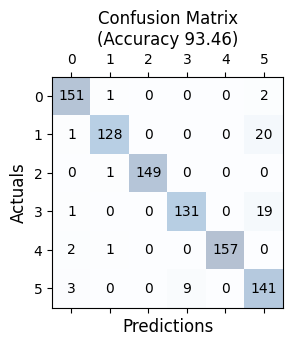

In [36]:
ref, hyp = results_dev['ref'], results_dev['hyp']

conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

That was pretty impressive, right!?! And  easier than Part I of this lab! 

Well, here comes some bad news: you can not use this langid classifier in the challenge. However, you can use the pre-trained x-vector embeddings as a feature extractor to train your language classification system (may be a simple K-means on top of the x-vectors work well). You can also try to change the classification head of the x-vector model and fine-tune with the challenge data. You have plenty of options, but remember, any system that use these pre-trained embeddings (or any similar ones) are only valid for the Track 2 of the Challenge and the prediction file should be  namedlike this: `T2_G<YY>_<SYSTEMID>.csv` 



# What should you deliver at the end of this lab assignment?
You should deliver the following three elements:
- You must submit at least one prediction file to the Kaggle competition in the format previously described: https://www.kaggle.com/competitions/speech-processing-lab-2/
- You must submit (via Fênix) the modified notebook (or code) of your proposed systems(s).
- You must submit a report (via Fênix) of maximum 2 pages describing your system, approaches (may be unsuccesful), lessons learnt, results on the dev partition, etc. You can use the following Overleaf template for the report: https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr

# Contacts and support
You can contact the professors during the classes or the office hours.

Particularly, for this second laboratory assignment, you should contact Prof. Alberto Abad: alberto.abad@tecnico.ulisboa.pt



